In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow_gpu-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)


In [1]:
#import the dependencies

import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#import tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#set gpu growth

#avoid oom errors by setting gpu memory consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# gpus
# no gpu

In [3]:
#create folder structures

POS_PATH = 'C:/Users/91701/Desktop/FRA MODEL/datas/positive'
NEG_PATH = 'C:/Users/91701/Desktop/FRA MODEL/datas/negative'
ANC_PATH = 'C:/Users/91701/Desktop/FRA MODEL/datas/anchor'


In [4]:
#MAKE THE DIRECTORIES

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/91701/Desktop/FRA MODEL/datas/positive'

In [4]:
LFW = 'C:/Users/91701/Desktop/FRA MODEL/lfw'

In [ ]:
#download the data

# https://vis-www.cs.umass.edu/lfw/

In [5]:
for directory in os.listdir(LFW):
    for file in os.listdir(os.path.join(LFW, directory)):
        EX_PATH = os.path.join(LFW, directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
#import the uuid lib to generate the unique image names
import uuid


In [7]:
##video and image capture code by opencv

#establish the connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[150:500, 200:500, :]
    
    #collects anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor images
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('w'):
        #create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor images
        cv2.imwrite(imgname, frame)
        dd
    
    
    #showing on the screen the picture
    cv2.imshow('image', frame)
    #breaking out gracefully by the power of break
    if cv2.waitKey(1) & 0XFF == ord('d'):
         break
#release the webcam            
cap.release()
#close the frame
cv2.destroyAllWindows()

In [8]:
#create pipelines using tensorflow for getting image directories

anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg' ).take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg' ).take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg' ).take(300)

In [9]:
##PREPROCESSING THE IMAGE

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img/255.0
    return img

In [50]:
# img = preprocess('C:/Users/91701/desktop/FRA MODEL/datas/anchor/5a2d5945-cf75-11ec-8b3d-fc34979596b6.jpg')

In [10]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
##train and test partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
result = preprocess_twin(*data.as_numpy_iterator().next())

In [13]:
result

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.21509804, 0.22411765, 0.27450982],
         [0.21176471, 0.22745098, 0.27058825],
         [0.2190196 , 0.23470588, 0.27784312],
         ...,
         [0.19941176, 0.21509804, 0.25823528],
         [0.1809804 , 0.20843138, 0.24764706],
         [0.17705883, 0.21235295, 0.2409804 ]],
 
        [[0.20960784, 0.22529413, 0.27235293],
         [0.21392156, 0.22960784, 0.2727451 ],
         [0.21568628, 0.23137255, 0.27450982],
         ...,
         [0.18607843, 0.21352941, 0.2527451 ],
         [0.1882353 , 0.21176471, 0.25882354],
         [0.18039216, 0.21176471, 0.25490198]],
 
        [[0.21078432, 0.2372549 , 0.2784314 ],
         [0.20490196, 0.22058824, 0.25784314],
         [0.21568628, 0.22843137, 0.26568627],
         ...,
         [0.19215687, 0.21568628, 0.2627451 ],
         [0.19117647, 0.21470588, 0.26960784],
         [0.1882353 , 0.21176471, 0.27254903]],
 
        ...,
 
        [[0.95490193, 0.97156864

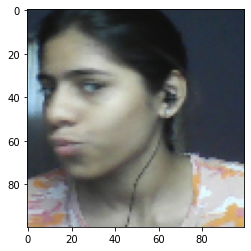

In [14]:
plt.imshow(result[1])

In [15]:
#build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

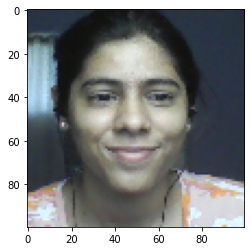

In [16]:
plt.imshow(data.as_numpy_iterator().next()[0])

In [17]:
#training partition

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

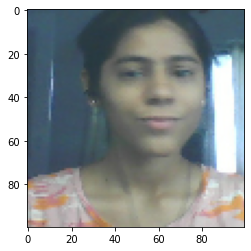

In [18]:
plt.imshow(train_data.as_numpy_iterator().next()[0][1])

In [19]:
#testing partition

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

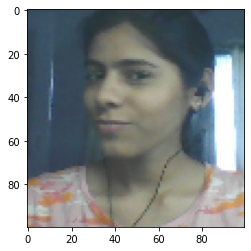

In [20]:
plt.imshow(test_data.as_numpy_iterator().next()[0][1])

In [21]:
inp = Input(shape = (100, 100, 3), name = 'input image')

#FIRST BLOCK
c1  = Conv2D(64, (10, 10), activation = 'relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
#SECOND BLOCK
c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
        #THIRD BLOCK
c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3) 
        #FINAL BLOCK
c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation = 'sigmoid')(f1)



In [22]:
##BUILDING EMBEDDED LAYER

def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input image')
    #FIRST BLOCK
    c1  = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    #SECOND BLOCK
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
    #THIRD BLOCK
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3) 
    #FINAL BLOCK
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [23]:
model = Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [24]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [25]:
embedding = make_embedding()

In [26]:
embedding

In [27]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding -  validation_embedding)

In [28]:
l1 = L1Dist()

In [29]:
l1

l1(anchor_embedding, validation_embedding)

make siamese model

In [30]:
def make_siamese_model():
    
    input_image = Input(name = 'input_img', shape = (100, 100, 3))
    
    validation_image = Input(name = 'validation_img', shape = (100, 100, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siameseNetwork')
    

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

TRAINING

In [33]:
##STEPUP LOSS AND OPTIMIZER

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
opt = tf.keras.optimizers.Adam(0.0001)

In [35]:
## establish checkpoint

checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [36]:
#building train step function

@tf.function

def train_step(batch):
    
    with tf.GradientTape() as tape:
        #get anchor and -ve/+ve image
        X = batch[:2]
        #get label
        Y = batch[2]
        
        #forward pass
        yhat = siamese_model(X, training = True)
        #calculate loss
        loss = binary_cross_loss(Y, yhat)
    
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate and updates the waits
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss
        
                        

In [37]:
#building a training loop

def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)
        #save checkpoints
        if epoch%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [38]:
##train the model-atlast

EPOCHS = 20

In [47]:
train(train_data, EPOCHS)


 Epoch 1/20
27/27 [==============================] - 452s 17s/step

 Epoch 2/20
27/27 [==============================] - 491s 18s/step

 Epoch 3/20
27/27 [==============================] - 517s 19s/step

 Epoch 4/20
27/27 [==============================] - 522s 19s/step

 Epoch 5/20
27/27 [==============================] - 446s 16s/step

 Epoch 6/20
27/27 [==============================] - 523s 19s/step

 Epoch 7/20
27/27 [==============================] - 384s 14s/step

 Epoch 8/20
27/27 [==============================] - 384s 14s/step

 Epoch 9/20
27/27 [==============================] - 386s 14s/step

 Epoch 10/20
27/27 [==============================] - 389s 14s/step

 Epoch 11/20
27/27 [==============================] - 385s 14s/step

 Epoch 12/20
27/27 [==============================] - 383s 14s/step

 Epoch 13/20
27/27 [==============================] - 383s 14s/step

 Epoch 14/20
27/27 [==============================] - 382s 14s/step

 Epoch 15/20
27/27 [======================

In [39]:
#EVALUATE OUR MODEL

#import metric calculations

from tensorflow.keras.metrics import Precision, Recall


In [40]:
#get a batch for test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [41]:
#make believe/predictions

predictions = siamese_model.predict([test_input, test_val])
predictions

array([[0.50005895],
       [0.49816668],
       [0.49886692],
       [0.49949056],
       [0.5001812 ],
       [0.50058794],
       [0.49998385],
       [0.49975988],
       [0.49998698],
       [0.50038445],
       [0.4987863 ],
       [0.49973342],
       [0.50000924],
       [0.49907526],
       [0.4987701 ],
       [0.49848986]], dtype=float32)

In [52]:
#post processing the results
[1 if predict > 0.5 else 0 for predict in predictions]

[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]

In [53]:
y_true #y_true matchs with the  predictions

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [54]:
m = Recall()

m.update_state(y_true, predictions)

m.result().numpy()

1.0

In [45]:
p = Precision()

p.update_state(y_true, predictions)

p.result().numpy()

0.0

In [56]:
#saving the model weights

siamese_model.save('SiameseModel.h5')

In [42]:
#reload the model
reload = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects = {'L1Dist': L1Dist, 'BianryCrossentropy': tf.losses.BinaryCrossentropy})
#

In [47]:
reload.predict([test_input, test_val])

array([[8.4252605e-09],
       [2.6326103e-07],
       [1.0000000e+00],
       [6.0646310e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.3033269e-08],
       [8.5326873e-10],
       [7.8458732e-01],
       [8.1706268e-08],
       [3.9755097e-09],
       [4.3824352e-10],
       [7.0488656e-01],
       [9.9999750e-01],
       [8.7855464e-01],
       [1.2116158e-09]], dtype=float32)

In [43]:
reload.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [44]:
##real time testing begins

#verification function:

def verify( model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('app_data', 'verification_image')):
        input_img = preprocess(os.path.join('app_data', 'input_images', 'input_images.jpg'))
        validation_img = preprocess(os.path.join('app_data', 'verification_image', image))
        
        #make predictions
        result = reload.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
                                
    #detection threshold                            
    detection = np.sum(np.array(results) > detection_threshold)
    #verification threshold                            
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_image')))
    verified = verification > verification_threshold
                                
    return results, verified

In [46]:
#REALTIME VERIFICATIONS

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[150:500, 200:500, :]
    
    cv2.imshow('verification', frame)
    
    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('r'):
        cv2.imwrite(os.path.join('app_data', 'input_images', 
                                 'input_images.jpg'), frame)
        
        #verification function
        results, verified = verify(reload, 0.5, 0.5)
        print(verified)
        
    
    if cv2.waitKey(10) & 0xFF == ord('d'):
        break
        
cap.release()
cv2.destroyAllWindows()

True
True
